In [2]:
using Images
using LinearAlgebra
using PyPlot
using Printf
using Statistics

In [3]:
# Load images from the yale_faces directory and return a MxN data matrix,
# where M is the number of pixels per face image and N is the number of images.
# Also return the dimensions of a single face image and the number of all face images
function loadfaces()
    
    # function for reading a single image and reshaping it properly
    readimg(root, file) = reshape(Float64.(PyPlot.imread(joinpath(root, file))),(:,1))
    
    # read all images in all subfolders
    data = [readimg(root, file) for (root, dirs, files) in walkdir("../data-julia/") for file in filter(x -> endswith(x, "pgm"), files)]
    
    # concatenate the array of arrays into a 2d array
    data = hcat(data...)
    
    # this is the same for all images, so we are lazy and hardcode it
    facedim = [96, 84]

    n = size(data,2)
  return data::Array{Float64,2},facedim::Array{Int},n::Int
end

loadfaces (generic function with 1 method)

In [4]:
# Apply principal component analysis on the data matrix.
# Return the eigenvectors of covariance matrix of the data, the corresponding eigenvalues,
# the one-dimensional mean data matrix and a cumulated variance vector in increasing order.
function computepca(data::Array{Float64,2})
    # mean-center the data
    mu = mean(data, dims=(2))
    X = data .- mu
    
    SVD = svd(X)
    # obtain eigenvectors
    U = SVD.U
    # obtain the eigenvalues by 1/N * S^2
    lambda = 1 / size(X,2) * SVD.S .^ 2
    # fraction of explained variance
    cumvar = cumsum(lambda / sum(lambda))
  return U::Array{Float64,2},lambda::Array{Float64,1},mu::Array{Float64,2},cumvar::Array{Float64,1}
end

computepca (generic function with 1 method)

In [5]:
# Plot the cumulative variance of the principal components
function plotcumvar(cumvar::Array{Float64,1})
    figure()
    PyPlot.plot(cumvar)
    PyPlot.show()
    return nothing::Nothing
end

plotcumvar (generic function with 1 method)

In [6]:
# Compute required number of components to account for (at least) 75/99% of the variance
function computecomponents(cumvar::Array{Float64,1})
    n75 = findfirst(cumvar .>= 0.75)
    n99 = findfirst(cumvar .>= 0.99)
  return n75::Int,n99::Int
end


# Display the mean face and the first 10 Eigenfaces in a single figure
function showeigenfaces(U::Array{Float64,2},mu::Array{Float64,2},facedim::Array{Int})
    nrows = 3
    ncols = 4
    f, axes = PyPlot.subplots(nrows,ncols)
    axes[1][:imshow](reshape(mu, facedim...), cmap="gray")
    axes[1][:set_title]("Mean face")
    
    for i in 1:10
        row = div(i, ncols) + 1
        col = mod(i, ncols) + 1
        axes[row, col][:imshow](reshape(U[:,i], facedim...), cmap="gray")
        axes[row, col][:set_title]("Eigenface $i")
    end
    for ax in axes
        ax[:axis]("off")
    end
    show()
  return nothing::Nothing
end


# Fetch a single face with given index out of the data matrix
function takeface(data::Array{Float64,2},facedim::Array{Int},n::Int)
    face = reshape(data[:,n], facedim...)
    return face::Array{Float64,2}
end


# Project a given face into the low-dimensional space with a given number of principal
# components and reconstruct it afterwards
function computereconstruction(faceim::Array{Float64,2},U::Array{Float64,2},mu::Array{Float64,2},n::Int)
    # reshape image into vector, but save the original dimensions
    dim = size(faceim)
    x = reshape(faceim, (:,1))
    
    # B contains the first n principal components
    B = U[:,1:n]
    # apply transformation
    a = transpose(B) * (x - mu)
    # do reconstruction
    recon = mu + B * a
    # reshape into original dimension
    recon = reshape(recon, dim)
  return recon::Array{Float64,2}
end

# Display all reconstructed faces in a single figure
function showreconstructedfaces(faceim, f5, f15, f50, f150)
    PyPlot.figure()
    f, axes = PyPlot.subplots(2,4)
    axes[1,1][:imshow](faceim, cmap="gray")
    axes[1,1][:set_title]("Original")
    
    axes[2,1][:imshow](f5, cmap="gray")
    axes[2,1][:set_title]("5 PC")
    
    axes[2,2][:imshow](f15, cmap="gray")
    axes[2,2][:set_title]("15 PC")
    
    axes[2,3][:imshow](f50, cmap="gray")
    axes[2,3][:set_title]("50 PC")
    
    
    axes[2,4][:imshow](f150, cmap="gray")
    axes[2,4][:set_title]("150 PC")
    
    for ax in axes
        ax[:axis]("off")
    end
  return nothing::Nothing
end

# Problem 2: Eigenfaces

function problem2()
  # load data
  data,facedim,N = loadfaces()

  # compute PCA
  U,lambda,mu,cumvar = computepca(data)

  # plot cumulative variance
  plotcumvar(cumvar)

  # compute necessary components for 75% / 99% variance coverage
  n75,n99 = computecomponents(cumvar)
  println(@sprintf("Necssary components for 75%% variance coverage: %i", n75))
  println(@sprintf("Necssary components for 99%% variance coverage: %i", n99))

  # plot mean face and first 10 Eigenfaces
  showeigenfaces(U,mu,facedim)

  # get a random face
  faceim = takeface(data,facedim,rand(1:N))

  # reconstruct the face with 5, 15, 50, 150 principal components
  f5 = computereconstruction(faceim,U,mu,5)
  f15 = computereconstruction(faceim,U,mu,15)
  f50 = computereconstruction(faceim,U,mu,50)
  f150 = computereconstruction(faceim,U,mu,150)

  # display the reconstructed faces
  showreconstructedfaces(faceim, f5, f15, f50, f150)

  return
end

problem2 (generic function with 1 method)

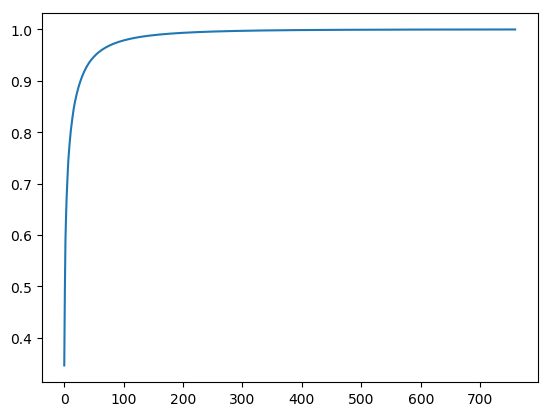

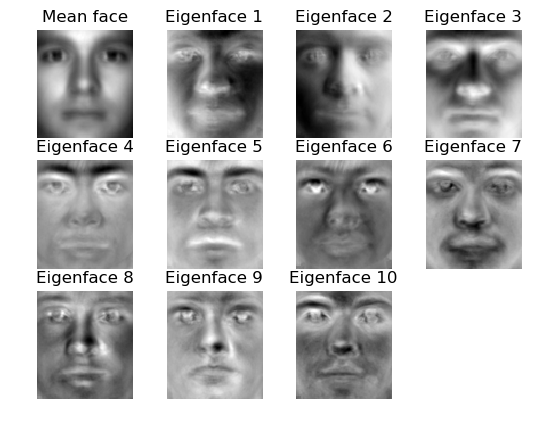

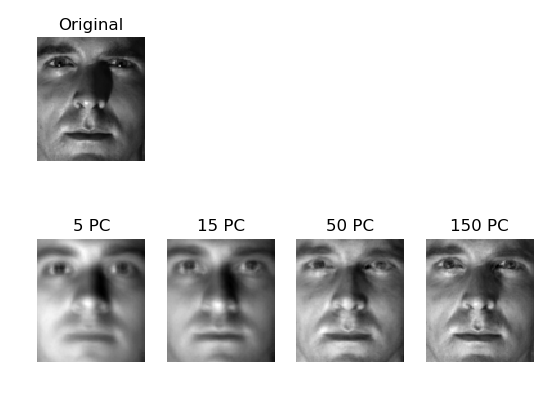

Necssary components for 75% variance coverage: 9
Necssary components for 99% variance coverage: 161


In [7]:
problem2()